In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import svm
import xgboost as xgb

In [188]:
!nvidia-smi

Sat Oct  9 09:07:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |     74MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

目錄
* Dataset
* 用了哪一些Model以及對應的準確率等表現
* 做了哪一些調整，改變，以及觀察到結果
* 如何選取 Top 3 important features
* 評估模型的Error Curve說明是否Overfit或者Underfit

In [189]:
path = 'drive/MyDrive/Colab Notebooks/data'
df_X = pd.read_csv(os.path.join(path,'X_train.csv'))
df_Y = pd.read_csv(os.path.join(path,'y_train.csv'))
x_test = pd.read_csv(os.path.join(path,'X_test.csv'))

#From Y, we know this is binary classify problem
print(np.unique(df_Y))

# Select Features
# X = X[['SHOT_DIST', 'TOUCH_TIME','CLOSE_DEF_DIST']]
# x_test = x_test[['SHOT_DIST', 'TOUCH_TIME','CLOSE_DEF_DIST']]
features_list = df_X.columns
display(df_X.head(5))
display(x_test.head(5))

X = df_X.to_numpy()
Y = df_Y.to_numpy()
x_test = x_test.to_numpy()

[0 1]


,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,3,595,11.3,1,1.8,3.9,2,0.3
1,2,530,11.0,0,1.0,24.3,3,6.3
2,1,221,21.3,2,1.9,3.5,2,11.5
3,3,442,9.0,0,0.6,2.4,2,3.4
4,1,634,16.1,0,0.8,4.2,2,1.6


In [190]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

#Standardization
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_valid_std = sc.fit_transform(x_valid)
x_test_std = sc.fit_transform(x_test)


(68600, 8) (68600, 1)
(17151, 8) (17151, 1)


用了哪一些模型以及其表現
1. RandomForestClassifier

    根據assignment需求，選擇了之前lab學過的RandomForestClassfier來
當作這次的模型。在還未做Hyperparameters調整，以及選取features前
，單純模型的執行結果為如下,看起來還蠻不錯了。
valid_acc = 0.62
2. XGBoost

    除了課堂教的模型外，這裡還額外選擇了XGBoost作為對比，objective
為binary:logistic, 也是跑出來約0.62的結果，證明該dataset給與的資訊
最多也只能讓模型達到6成的準確率效果。
valid_acc = 0.61

**Model1 : RandomForestClassfier**

In [191]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50, random_state=0)
model.fit(x_train_std, y_train.ravel())

y_train_pred = model.predict(x_train_std)
y_valid_pred = model.predict(x_valid_std)
y_test_pred = model.predict(x_test_std)

print('\n====== RandomForestClassifier ======')
print('MSE train: %.2f, valid: %.2f ' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_valid, y_valid_pred)))

print('Acc train: %.2f, valid: %.2f ' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))
print('====================================')


====== RandomForestClassifier ======
MSE train: 0.36, valid: 0.39 
Acc train: 0.64, valid: 0.61 


**Model2: XGBoost**

In [192]:
parameters = {'eval_metric':'error', 
              'colsample_bytree':'0.5',
              'subsample':'0.80',
              'gpu_id':'0',
              'tree_method':'gpu_hist',
              'learning_rate':'0.1'
             }

XGB = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=100)
model = XGB.fit(x_train_std, y_train.ravel(), eval_metric=["error", "logloss"], eval_set=[(x_train_std, y_train), (x_valid_std, y_valid)], verbose=False)
# print(model)
# xgb.plot_importance(model)
# model.get_xgb_params()


y_train_pred = model.predict(x_train_std)
y_valid_pred = model.predict(x_valid_std)
y_test_pred = model.predict(x_test_std)

print('\n====== XGBoost ======')
print('MSE train: %.2f, valid: %.2f ' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_valid, y_valid_pred)))

print('Acc train: %.2f, valid: %.2f ' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))
print('=====================')


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



====== XGBoost ======
MSE train: 0.38, valid: 0.39 
Acc train: 0.62, valid: 0.61 


繪製 XGB 的 logloss, 以及 Classification Error

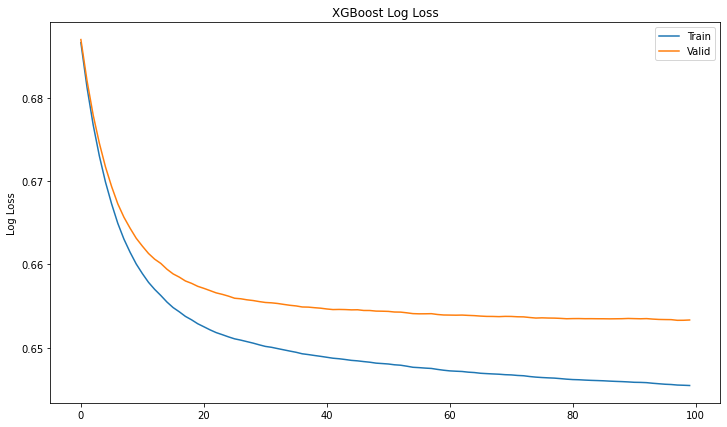

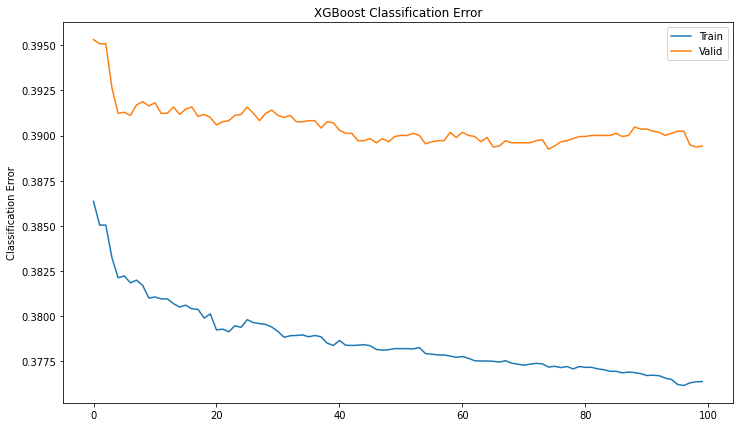

In [193]:
result = model.evals_result()

epochs = len(result['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(x_axis, result['validation_0']['logloss'], label='Train')
ax.plot(x_axis, result['validation_1']['logloss'], label='Valid')
ax.legend()

plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(x_axis, result['validation_0']['error'], label='Train')
ax.plot(x_axis, result['validation_1']['error'], label='Valid')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


做了哪一些調整，改變，以及觀察到結果
1. 調整過train 和 valid dataset 的比例(7:3, 8:2)，但似乎結果都沒有太大
差別，都是落在0.61~0.62左右。

2. 通過增加模型樹的深度，來使模型複雜度提高，是可以使得模型的準確
率上升，但是valid_mse下降的值最大只有約為0.02, valid_acc上升0.02
。


 如何選取 Top 3 important features
1. 通過課堂上教過的Lasso，設定alpha=0.01, epsilon=1e-2，可以得到四
個features， 分別是 ‘SHOT_CLOCK’, ‘TOUCH_TIME’, ‘SHOT_DIST’,
‘CLOSE_DEF_DIST’。

2. 再來是通過XGBoost模型defined的API，features_important_會顯示出
模型中的features權重比值，可以從中看出哪一些features比較重要。

3. 因此我選擇了 SHOT_DIST, CLOSE_DEF_DIST, TOUCH_TIME 這三
個features為主。


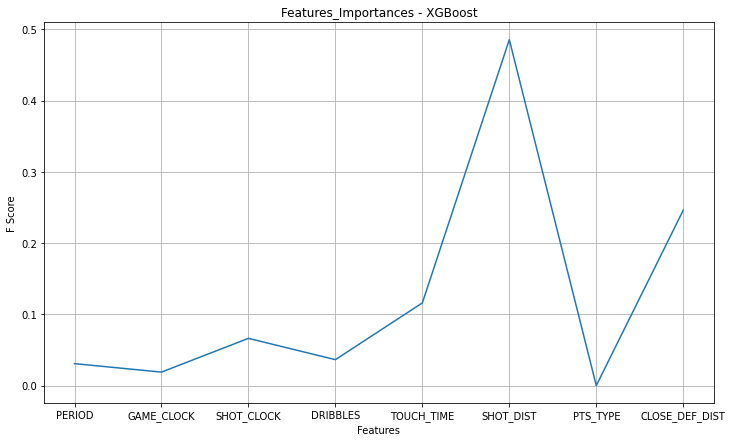



Lasso Selected attributes: ['SHOT_CLOCK' 'TOUCH_TIME' 'SHOT_DIST' 'CLOSE_DEF_DIST']


In [194]:
# XGB features_important_
plt.subplots(figsize=(12,7))
plt.plot(features_list, model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('F Score')
plt.title('Features_Importances - XGBoost')
plt.grid('True')
plt.show()

# Features Selection From Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(x_train_std, y_train)

epsilon = 1e-2
idxs = np.where(abs(lasso.coef_) > epsilon)
print('\n\nLasso Selected attributes: {}'.format(df_X.columns.values[idxs]))

**Retrain our model with the 3 most important features**

In [195]:
df_X = pd.read_csv(os.path.join(path,'X_train.csv'))
df_Y = pd.read_csv(os.path.join(path,'y_train.csv'))
x_test = pd.read_csv(os.path.join(path,'X_test.csv'))

df_X = df_X[['SHOT_DIST', 'TOUCH_TIME','CLOSE_DEF_DIST']]
x_test = x_test[['SHOT_DIST', 'TOUCH_TIME','CLOSE_DEF_DIST']]

features_list = df_X.columns
X = df_X.to_numpy()
Y = df_Y.to_numpy()
x_test = x_test.to_numpy()

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.4, random_state=42)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

#Standardization
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_valid_std = sc.fit_transform(x_valid)
x_test_std = sc.fit_transform(x_test)

mse_rfc, mse_xgb = [], []
acc_rfc, acc_xgb = [], []
for depth in range(1,10):
  print('depth: ',depth)
  # RandomForest with 3 features
  model = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=50, random_state=42)
  model.fit(x_train_std, y_train.ravel())

  y_train_pred = model.predict(x_train_std)
  y_valid_pred = model.predict(x_valid_std)
  y_test_pred = model.predict(x_test_std)

  print('====== RandomForestClassifier ======')
  print('MSE train: %.2f, valid: %.2f ' % (
                  mean_squared_error(y_train, y_train_pred),
                  mean_squared_error(y_valid, y_valid_pred)))
  mse_rfc.append(mean_squared_error(y_valid, y_valid_pred))
  print('Acc train: %.2f, valid: %.2f ' % (
                  accuracy_score(y_train, y_train_pred),
                  accuracy_score(y_valid, y_valid_pred)))
  acc_rfc.append(accuracy_score(y_valid, y_valid_pred))
  print('====================================\n')

  # XGBoost with 3 features
  parameters = {'eval_metric':'error', 
                'colsample_bytree':'0.5',
                'subsample':'0.80',
                'gpu_id':'0',
                'tree_method':'gpu_hist',
                'learning_rate':'0.001'
              }
  XGB = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=100, max_depth=depth)
  model = XGB.fit(x_train_std, y_train.ravel(), eval_metric=["error", "logloss"], eval_set=[(x_train_std, y_train.ravel()), (x_valid_std, y_valid.ravel())], verbose=False)

  y_train_pred = model.predict(x_train_std)
  y_valid_pred = model.predict(x_valid_std)
  y_test_pred = model.predict(x_test_std)

  print('====== XGBoost ======')
  print('MSE train: %.2f, valid: %.2f ' % (
                  mean_squared_error(y_train, y_train_pred),
                  mean_squared_error(y_valid, y_valid_pred)))
  mse_xgb.append(mean_squared_error(y_valid, y_valid_pred))
  print('Acc train: %.2f, valid: %.2f ' % (
                  accuracy_score(y_train, y_train_pred),
                  accuracy_score(y_valid, y_valid_pred)))
  acc_xgb.append(accuracy_score(y_valid, y_valid_pred))
  print('=====================\n')

(51450, 3) (51450, 1)
(34301, 3) (34301, 1)
depth:  1
====== RandomForestClassifier ======
MSE train: 0.41, valid: 0.41 
Acc train: 0.59, valid: 0.59 

====== XGBoost ======
MSE train: 0.39, valid: 0.39 
Acc train: 0.61, valid: 0.61 

depth:  2
====== RandomForestClassifier ======
MSE train: 0.39, valid: 0.39 
Acc train: 0.61, valid: 0.61 

====== XGBoost ======
MSE train: 0.38, valid: 0.39 
Acc train: 0.62, valid: 0.61 

depth:  3
====== RandomForestClassifier ======
MSE train: 0.39, valid: 0.39 
Acc train: 0.61, valid: 0.61 

====== XGBoost ======
MSE train: 0.38, valid: 0.39 
Acc train: 0.62, valid: 0.61 

depth:  4
====== RandomForestClassifier ======
MSE train: 0.38, valid: 0.38 
Acc train: 0.62, valid: 0.62 

====== XGBoost ======
MSE train: 0.37, valid: 0.38 
Acc train: 0.63, valid: 0.62 

depth:  5
====== RandomForestClassifier ======
MSE train: 0.38, valid: 0.38 
Acc train: 0.62, valid: 0.62 

====== XGBoost ======
MSE train: 0.37, valid: 0.39 
Acc train: 0.63, valid: 0.61 

d

評估 Error Curve 是否有Overfit 或者 Underfit
1. 以下的圖顯示以上提到的兩個模型對Valid dataset在隨著模型的複雜度
提高時，準確率也會提升，但是對於RFC來說最好的深度是Depth 7可以
使得準確率最高，對於XGB最好的準確率是在Depth 4。

2. loss的話，RFC是Depth為7最低，XGB是Depth為4最低，和Acc的表現
相呼應。


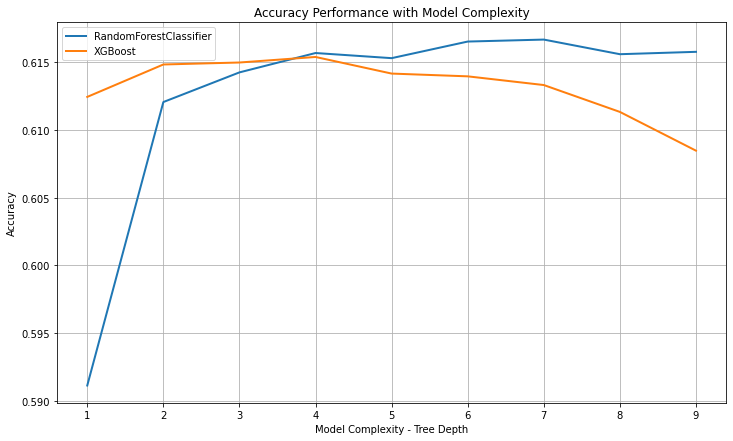

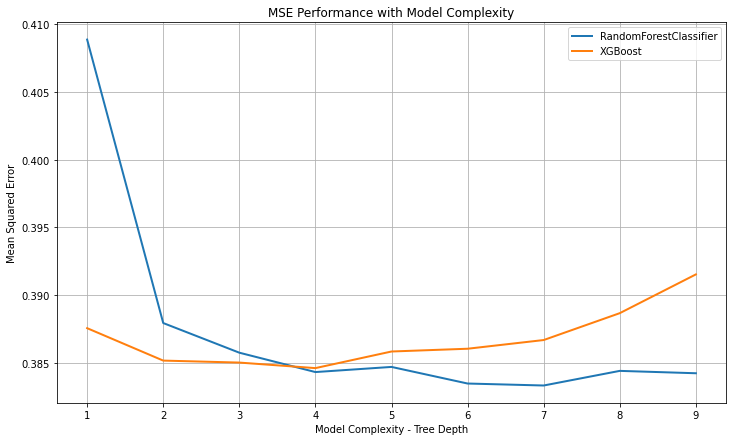

In [196]:
plt.subplots(figsize=(12,7))
plt.plot(range(1,10), acc_rfc, label='RandomForestClassifier', linewidth=2)
plt.plot(range(1,10), acc_xgb, label='XGBoost', linewidth=2)
plt.xlabel('Model Complexity - Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Performance with Model Complexity')
plt.grid('True')
plt.show()

plt.subplots(figsize=(12,7))
plt.plot(range(1,10), mse_rfc, label='RandomForestClassifier',linewidth=2)
plt.plot(range(1,10), mse_xgb, label='XGBoost',linewidth=2)
plt.xlabel('Model Complexity - Tree Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE Performance with Model Complexity')
plt.grid('True')
plt.show()

最後選表現最好的RFC單獨來跑depth，選出MSE最低的Depth，預測
x_test的target values。

* RFC的Validate Error最低是Depth 8

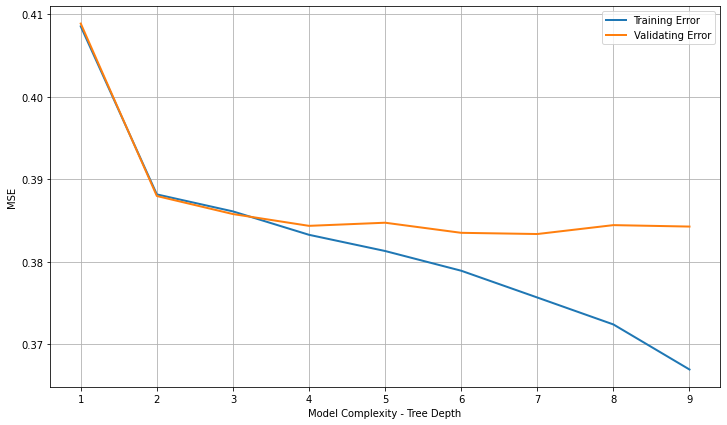

In [197]:
mse_train, mse_valid = [], []
max_depth = 10
for depth in range(1, max_depth):
  model = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=50, random_state=42)
  model.fit(x_train_std, y_train.ravel())

  y_train_pred = model.predict(x_train_std)
  y_valid_pred = model.predict(x_valid_std)

  mse_train.append(mean_squared_error(y_train, y_train_pred))
  mse_valid.append(mean_squared_error(y_valid, y_valid_pred))

plt.subplots(figsize=(12,7))
plt.plot(range(1,max_depth), mse_train, label='Training Error', linewidth=2)
plt.plot(range(1,max_depth), mse_valid, label='Validating Error', linewidth=2)
plt.xlabel('Model Complexity - Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.grid('True')
plt.savefig('fig-error-curve.png', dpi=300)
plt.show()


# Save output
model = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50, random_state=42)
model.fit(x_train_std, y_train.ravel())
y_test_pred = model.predict(x_test_std)
y_test_pred = pd.DataFrame(y_test_pred, columns=['FGM'])
y_test_pred.to_csv('y_pred.csv', index=False)
